# 2 Extract Features
Summary:
1. In this script we extract the Lab & mannequin values 
2. We apply a query based approach to parse features from the narrative of the EMR [WIP]

In [3]:
PATH_SCRIPTS= r'../src/scripts'
PATH_MODULES= r'/exports/reum/tdmaarseveen/modules/' # unused
PATH_FILES = r"../../EMR_mining/output_files/"

import sys
sys.path.append(PATH_SCRIPTS)
sys.path.append(r'../src/1_emr_scripts')
#sys.path.append(PATH_MODULES)

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import medExtract as me

### Select patients + first date

In [5]:
import pandas as pd
df_pat = pd.read_csv(r'../filters/RA_patients_083_new.csv', sep=',', index_col=0)
new_pat = dict(zip(df_pat.PATNR, df_pat.PEC))
print(len(new_pat.keys()))

1251


## #1. Extract Lab values
### #1.1 Read raw table 
- read raw csv
- filter out the irrelevant columns

### (A) New extraction [UNUSED]
- this is currently unused because of less data

In [2]:
import pandas as pd
df_lab = pd.read_csv(r'../data/1_raw/Clustering_LAB_values_NewCutoff_2.csv', sep=';') #new_pat # sep=';',

df_lab = df_lab[['effectiveDateTime', 'code_display_original', 'valueQuantity_value', 'valueQuantity_code_original', 'subject_Patient_value', 'valueString']]
df_lab.columns = ['Monster_Afname_Datumtijd', 'test_naam_omschrijving', 'uitslag_value', 'uitslag_unit', 'patient_id', 'uitslag_text']


# Rename columns
cols= ['PseudoID', 'Aanvraagnummer', 'Onderzoek', 'Onderzoek_code',
       'Resultaat_Status_Code', 'toelichting', 'Resultaat_type',
       'Resultaat_type_code', 'test_naam_code', 'test_naam_omschrijving',
       'uitslag_value', 'uitslag_unit', 'uitslag_text',
       'Referentie_Ondergrens_Value', 'Referentie_ondergrens_Unit',
       'Referentie_Bovengrens_Value', 'Referentie_Bovengrens_Unit',
       'Resultaat_Vlaggen_Code', 'monster_Materiaal',
       'monsterMateriaal_toelichting', 'Broncode', 'Monster_Afname_Datumtijd',
       'patient_id']

df_lab = pd.read_csv(r'../data/1_raw/Clustering_LAB_values_NewCutoff.csv', sep=';') #new_pat # sep=';',
df_lab.columns = cols

# Key file linking pseudo ids and patient ids
df_keys = pd.read_csv(r'../data/1_raw/Pseudonymized_Keys.csv', sep=';')
d_translation = dict(zip(df_keys.member_entity_Pseudonym_value, df_keys.member_entity_Patient_value))

# create a selection of the data
df_lab = df_lab.reset_index(drop=True)
df_lab[['Monster_Afname_Datumtijd',  'test_naam_omschrijving',
       'uitslag_value', 'uitslag_unit', 'patient_id', 'uitslag_text']].to_csv(r'../data/1_raw/Clustering_LAB_values_selection.csv', sep='|', index=False)

### (B) Old extraction

In [ ]:
import pandas as pd
df_lab = pd.read_csv(r'../data/1_raw/Clustering_LAB_values_NewCutoff.csv', sep=';') #new_pat # sep=';',

# create a selection of the data
df_lab = df_lab.reset_index(drop=True)
df_lab = df_lab[['Monster_Afname_Datumtijd',  'test_naam_omschrijving',
       'uitslag_value', 'uitslag_unit', 'patient_id', 'uitslag_text']]

df_lab.to_csv(r'../data/1_raw/Clustering_LAB_values_selection.csv', sep='|', index=False)

df_lab.head()

### #1.2 Show unique prescriptions added per day

Text(-0.1, 0.5, 'Number of dossier entries')

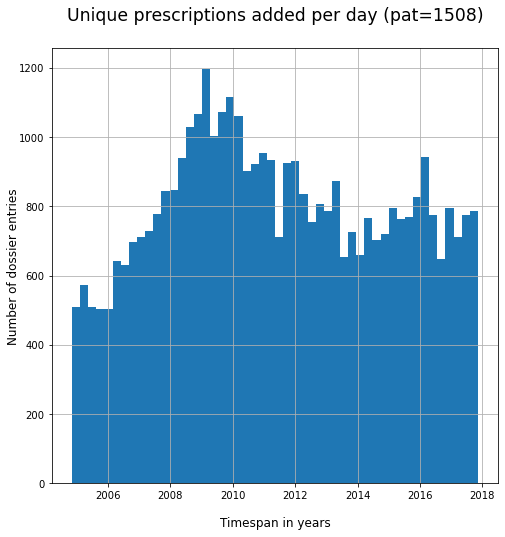

In [30]:
import matplotlib.pyplot as plt 

df_crp = df_lab[df_lab['test_naam_omschrijving']=='C-Reaktief Proteïne'].copy() # ['Monster_Afname_Datumtijd'].min()
df_crp = df_crp.reset_index()
plt.rcParams.update({'font.size': 10})
df_crp['Monster_Afname_Datumtijd'] = pd.DatetimeIndex(pd.to_datetime(df_crp['Monster_Afname_Datumtijd'])).tz_localize('UTC')
fig2 = df_crp.groupby(['index'])['Monster_Afname_Datumtijd'].nsmallest(1).hist(bins=50, figsize = (8,8)) 

fig2.set_title('Unique prescriptions added per day (pat=1508)', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig2.text(0.5, -0.1, 'Timespan in years', ha='center', fontsize='large', transform=fig2.transAxes)
fig2.text(-0.1, 0.5, 'Number of dossier entries', va='center', rotation='vertical', fontsize='large', transform=fig2.transAxes)

### #1.3 Get eligible patients

In [11]:
df_pat = pd.read_csv(r'../filters/RA_patients_083_new.csv', sep=',', index_col=0)
new_pat = dict(zip(df_pat.PATNR, df_pat.NEW_PEC))

### #1.4 Collect lab data from initial clinical presentation

Date tolerance:
- Serology : accept serological values +/- 1 yr from consult (as serology doesn't change over night)
- Other lab values: accept everything up til 3 months after first consult

In [ ]:
c_date = 'Monster_Afname_Datumtijd' # 'Monster_Afname_Datumtijd'
c_test = 'test_naam_omschrijving' # 'test_naam_omschrijving'
c_pat = 'patient_id' # 'patient_id'


new_df = pd.DataFrame()
df_lab = df_lab[df_lab[c_pat].isin(new_pat.keys())]
cnt = 0

for pat in new_pat.keys():
    # Serology - ACPA / RF (+/- 1 yr
    
    try : 
        # Serology - ACPA / RF (+/- 1 yr)
        l_ser = ['IgM reumafactor', 'Anti-CCP', 'Anti-CCP Kwant.', 'Anti nucleaire antistoffen (ANA)', 'ANF', 'Anti-ENA',
       'Anti-ENA Kwant.', 'Anti-SS-A', 'Anti-SS-A Kwant.']
        
        sub_df2 = df_lab[((df_lab[c_pat]==pat) & (df_lab[c_test].isin(l_ser)))].copy() # select pat
        ser_min_date = new_pat[pat] # get date of first consult
        ser_min_date = pd.to_datetime(ser_min_date, format='%Y-%m-%d', errors='ignore')
        ser_max_date = ser_min_date + pd.DateOffset(years=1) #pd.Timedelta(3, unit='M') # three months from first consult
        ser_min_date = ser_min_date - pd.DateOffset(years=1)
        sub_df2[c_date] = pd.DatetimeIndex(pd.to_datetime(sub_df2[c_date], format='%Y-%m-%d', errors='ignore')).tz_localize('UTC')
        sub_df2 = sub_df2[sub_df2[c_date].between(ser_min_date, ser_max_date, inclusive=False)]
        new_df = new_df.append(sub_df2, ignore_index=True)
        
        # Other features (+ 3mo)
        sub_df = df_lab[((df_lab[c_pat]==pat) & (~df_lab[c_test].isin(l_ser)))].copy() # select pat
        min_date = new_pat[pat] # get date of first consult
        min_date = pd.to_datetime(min_date, format='%Y-%m-%d', errors='ignore')
        max_date = min_date + pd.DateOffset(months=3) #pd.Timedelta(3, unit='M') # three months from first consult
        sub_df[c_date] = pd.DatetimeIndex(pd.to_datetime(sub_df[c_date], format='%Y-%m-%d', errors='ignore')).tz_localize('UTC')
        sub_df = sub_df[sub_df[c_date].between(min_date, max_date, inclusive=False)]
        new_df = new_df.append(sub_df, ignore_index=True)
    except KeyError:
        print('%s not in Lab dataframe' % pat)
        continue
    cnt += 1
    if cnt % 100 == 0 :
            print(str(cnt) + 'th iteration')
    #if cnt > 5:
    #    break
new_df.to_csv(r'../data/2_preprocessing/DF_Lab_firstCon_3.csv', sep='|', index=True)
new_df.head()

## #2. Extract Mannequin 

### #2.1 Check completeness of mannequin
- at baseline the mannequin should be rather complete
- but after baseline you can expect a lot of missingness

In [ ]:
import pandas as pd
df_ddra = pd.read_csv(r'../data/1_raw/Clustering_Gewrichtspop_v2.csv', sep=';', header=None)
df_ddra.columns = ['ID', 'STELLING', 'CATEGORIE', 'XANTWOORD', 'DATUM_A', 'PATNR', 'OBJID', 'DATUM', 'BEHANDELAAR']
df_keys = pd.read_csv(r'../data/1_raw/Pseudonymized_Keys.csv', sep=';')
d_translation = dict(zip(df_keys.member_entity_Pseudonym_value, df_keys.member_entity_Patient_value))
df_ddra['PATNR'] = df_ddra['PATNR'].apply(lambda x: d_translation[x])
df_ddra.head()

In [ ]:
import pandas as pd
df_ddra = pd.read_csv(r'../data/1_raw/Clustering_Gewrichtspop.csv', sep=';', header=None)
df_ddra.columns = ['ID','PATNR','DATUM','DATUM_A', 'STELLING', 'ANTWOORD', 'XANTWOORD', 'YANTWOORD', 'CATEGORIE', 'OBJID']
df_ddra.head()

#### Collect mannequin features around baseline

In [ ]:
#df_ddra[df_ddra['PATNR'].isin(new_pat)] # subset - > check completeness
import pandas as pd
new_df = pd.DataFrame()
cnt = 0

for pat in df_ddra['PATNR'].unique():
    sub_df = df_ddra[df_ddra['PATNR']==pat].copy() # select pat
    try : 
        min_date = new_pat[pat] # get date of first consult
        min_date = pd.to_datetime(min_date, format='%Y-%m-%d', errors='ignore')
        max_date = min_date + pd.Timedelta(93, unit='d') # three months from first consult
        min_date = min_date - pd.DateOffset(days=1) # maybe a day earlier
        sub_df['DATUM'] = pd.to_datetime(sub_df['DATUM'], format='%Y-%m-%d', errors='ignore')
        sub_df = sub_df[sub_df['DATUM'].between(min_date, max_date, inclusive=False)]
        new_df = new_df.append(sub_df, ignore_index=True)
    except KeyError:
        continue
    cnt += 1

new_df.to_csv(r'../data/2_preprocessing/DF_Mannequin_NEW_firstCon_2.csv', sep='|', index=True)
new_df.head()
# x-axis = date
# heatmaps
# boxplot -> Mean availability at baseline, at 1 month, at 3 months for every variable.
# patientnr

## #3. Extract BMI [Unused]

In [ ]:
import pandas as pd

cols= ['ID','BMI', 'Lengte_value', 'Gewicht_value', 'Datum', 'PATNR']#

#df_bmi = pd.read_csv(r'../data/1_raw/Clustering_BMI.csv', sep=';') #new_pat # sep=';',
#df_bmi.columns = cols
#df_bmi = df_bmi.reset_index(drop=True)
#df_bmi.to_csv(r'../data/1_raw/Clustering_BMI.csv', sep='|', index=False)

df_bmi = pd.read_csv(r'../data/1_raw/Clustering_BMI.csv', sep='|', index_col=0)
df_bmi = df_bmi[df_bmi['PATNR'].isin(new_pat.keys())]
df_bmi.head()

## #4. Extract Age and Sex

In [ ]:
import pandas as pd

cols= ['ID','PATNR', 'DATUM_A', 'STELLING', 'XANTWOORD', 'CATEGORIE', 'OBJID']

#df_age_sex = pd.read_csv(r'../data/1_raw/Clustering_Age_Sex.csv', sep=';') #new_pat # sep=';',
#df_age_sex.columns = cols
#df_age_sex = df_age_sex.reset_index(drop=True)
#df_age_sex.to_csv(r'../data/1_raw/Clustering_Age_Sex.csv', sep='|', index=False)

df_age_sex = pd.read_csv(r'../data/1_raw/Clustering_Age_Sex.csv', sep='|', index_col=0)
df_age_sex.head()

In [6]:
len(df_age_sex[df_age_sex['STELLING'].str.contains('Geslacht')]['PATNR'].unique())

840

#### Export demographic data to csv

In [ ]:
df_ddra = df_ddra[df_ddra['PATNR'].astype(float).isin(new_pat.keys())]
df_ddra.to_csv(r'../data/2_processed/DF_LeeftijdenGeslacht.csv', sep='|', index=True)
df_ddra.head()

## #5. Extract Alcohol / Smoking [Unused]
- ToDo: Where do we extract this information from??

In [ ]:
import pandas as pd

cols= ['ID','PATNR', 'DATUM', 'DATUM_A', 'STELLING', 'XANTWOORD', 'CATEGORIE', 'OBJID']

#df_env = pd.read_csv(r'../data/1_raw/Clustering_Env.csv', sep=';') #new_pat # sep=';',
#df_env.columns = cols
#df_env = df_env.reset_index(drop=True)
#df_env.to_csv(r'../data/1_raw/Clustering_Env.csv', sep='|', index=False)

df_env = pd.read_csv(r'../data/1_raw/Clustering_Env.csv', sep='|', index_col=0)
df_env.head()

In [18]:
df_env = df_env[df_env['PATNR'].astype(float).isin(new_pat.keys())]
len(df_env[df_env['STELLING'].str.contains('Roken')]['PATNR'].unique()), len(df_env[df_env['STELLING'].str.contains('Alcohol')]['PATNR'].unique())

(459, 449)